In [1]:
import cProfile
import pstats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from simulate import simulate
import simulation

plant_kwargs = {
    'r_min': 0.00001,
    'r_max': 0.03,
    'growth_rate': 0.0001,
    'reproduction_chance': 0.1,
}

simulation_kwargs = {
                'num_plants': 1000,
                'half_width': 0.5,
                'half_height': 0.5,
                'qt_capacity': 1,
                'land_quality': 0.01,
                'density_check_range': 0.1
            }

def run_simulation():
    sim = simulation.initialize_random(**simulation_kwargs, **plant_kwargs)
    
    # Add plants and run steps
    for t in range(1000):
        sim.step()
        print(f'Step {t}' + ' '*20, end='\r')

# Profile the simulation
cProfile.run('run_simulation()', 'profile_output')

# Load the profile data
p = pstats.Stats('profile_output')

# Convert the profile data to a DataFrame
profile_data = []
for func, (cc, nc, tt, ct, callers) in p.stats.items():
    profile_data.append({
        'function': pstats.func_std_string(func),
        'call_count': cc,
        'total_time': tt,
        'cumulative_time': ct,
        'per_call_time': tt / nc if nc else 0,
        'per_call_cumulative_time': ct / cc if cc else 0
    })

df = pd.DataFrame(profile_data)

# Sort and display the top 20 functions by cumulative time
df.sort_values(by='cumulative_time', ascending=False, inplace=True)


pygame 2.6.0 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [18]:
i = 4
print(df.iloc[i]['function'])
df.iloc[i]

c:\Users\carla\Dropbox\_CARL\UNI\MASTER PROJECT\Code\quadT.py:250(query)


function                    c:\Users\carla\Dropbox\_CARL\UNI\MASTER PROJEC...
call_count                                                            2069060
total_time                                                         315.880157
cumulative_time                                                    917.486812
per_call_time                                                        0.000002
per_call_cumulative_time                                             0.000443
Name: 530, dtype: object

In [ ]:

# Sort and display the top 20 functions by cumulative time
df.sort_values(by='cumulative_time', ascending=False, inplace=True)

i = 4
print(df.iloc[i]['function'])
df.iloc[i]

In [3]:
figs = []
axs = []

reproduction_chances = [0.1]
land_qualities = [0.01]
density_check_factors = [1, 5, 10, 20, 30, 40, 50, 80, 100]

i = 4
for d_factor in density_check_factors:
    for reproduction_chance in reproduction_chances:
        for land_quality in land_qualities:
            
            print(f'reproduction_chance: {reproduction_chance},\nland_quality: {land_quality},\ndensity_check_factor: {d_factor}')

            prefix = 'sim' + str(i + 1)

            save_file = True
            render = False

            seed = 0
            np.random.seed(seed)

            num_plants = 250
            n_iter = 10_000

            half_width = half_height = 0.5
            A_bound = 2 * half_width * 2 * half_height

            m2pp = m2_per_plant = 1_000  # m2/plant
            _m = np.sqrt(A_bound/(m2pp*num_plants))
            print(f'1 m = {_m} u')
            print(f'1 u = {1/_m} m')

            # Initialize simulation
            plant_kwargs = {
                'r_min': 0.01 * _m,
                'r_max': 30 * _m,
                'growth_rate': 0.1 * _m,
                # 'reproduction_chance': 1.0
                'reproduction_chance': reproduction_chance
            }

            simulation_kwargs = {
                'half_width': half_width,
                'half_height': half_height,
                'qt_capacity': 1,
                # 'land_quality': 0.0,
                'land_quality': land_quality,
                # 'density_check_range': 100 * _m
                'density_check_range': d_factor * _m
            }

            states, metadata = simulate(num_plants, n_iter, seed, plant_kwargs,
                                        simulation_kwargs, save_file=save_file, file_prefix = prefix, render=render)
            i+=1


            ########################################
            biomass_densities = []
            num_densities = []

            for state in states[:-1]:
                plants_in_state = [point.data for point in state.all_points()]
                biomass_density = sum([plant.A for plant in plants_in_state])/state.boundary.area
                num_density = len(plants_in_state)/(state.boundary.area)/num_plants# * _m**2)
                biomass_densities.append(biomass_density)
                num_densities.append(num_density)
                
            fig, ax = plt.subplots()
            ax.set_title(f'biomass and density vs time ({prefix})')
            ax.plot(num_densities, label='density')
            ax.plot(biomass_densities, label='biomass')
            plt.legend()
            figs.append(fig)
            axs.append(ax)
            plt.show()

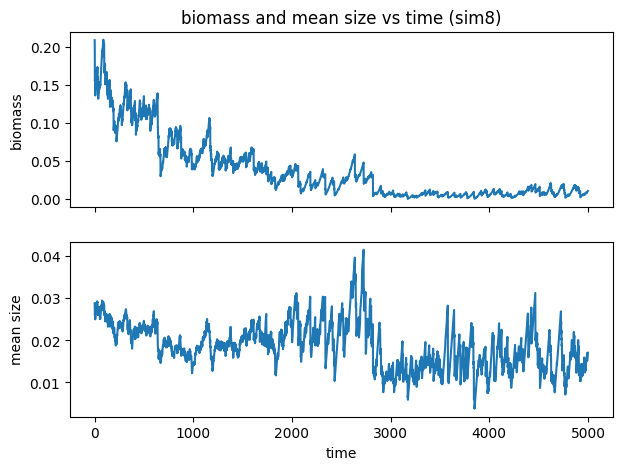

0.0


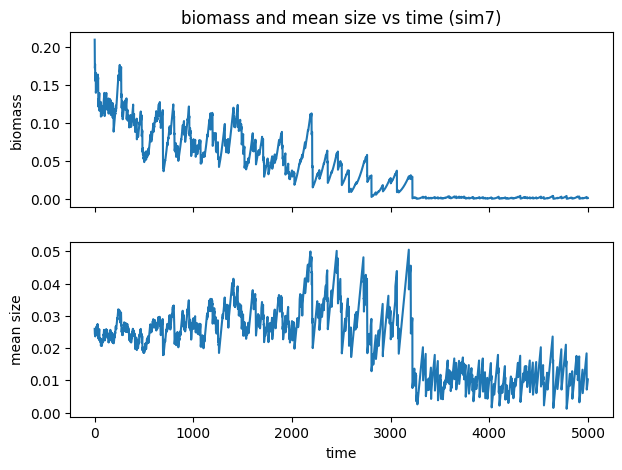

0.0


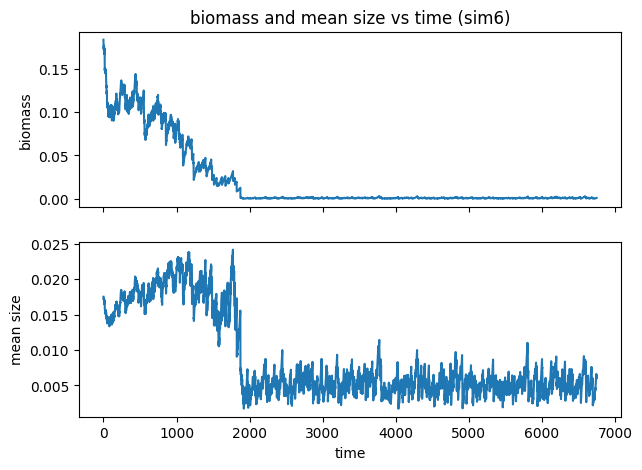

0.0


C:\Users\carla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\carla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


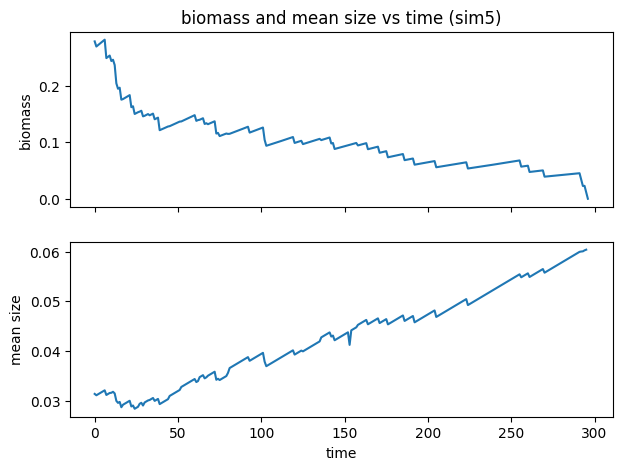

0.01


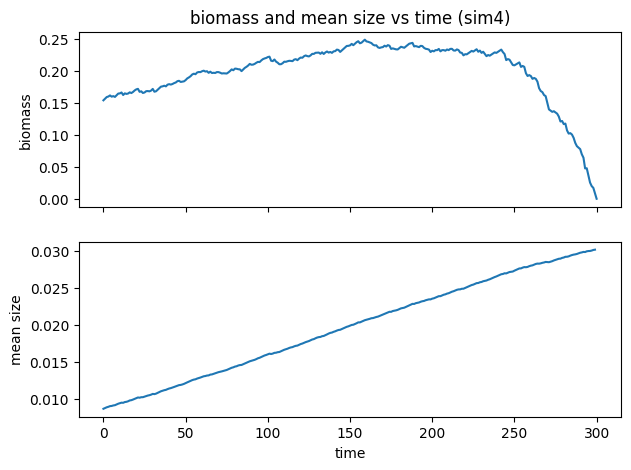

0.1


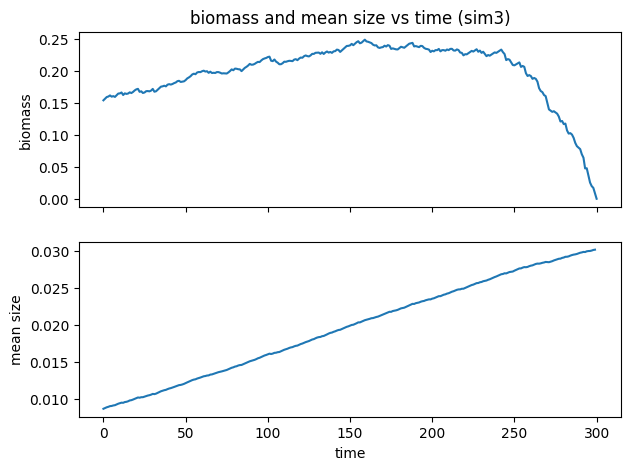

0.0


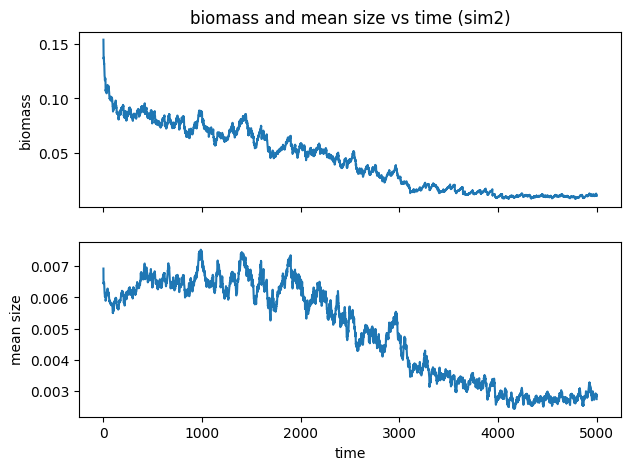

0.1


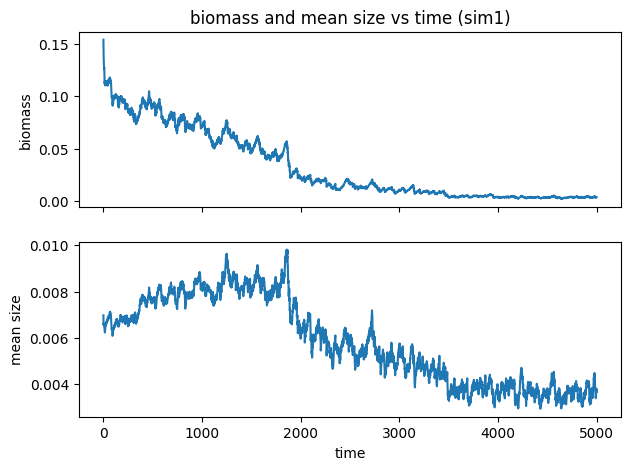

0.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def load_metadata(file_path):
    with open(file_path, 'rb') as file:
        metadata = pickle.load(file)
    return metadata


def load_states_in_chunks(file_path, chunk_size):
    with open(file_path, 'rb') as file:
        while True:
            try:
                chunk = pickle.load(file)
                for i in range(0, len(chunk), chunk_size):
                    yield chunk[i:i + chunk_size]
            except EOFError:
                break
            
            
for i in range(1,9)[::-1]:            
    prefix = f'sim{i}'
    file_path_metadata = f'Data\{prefix}_metadata.pkl'
    file_path_states = f'Data\{prefix}_states.pkl'

    metadata = load_metadata(file_path_metadata)

    total_states = n_iter = metadata['n_iter']
    chunk_size = metadata['chunk_size']

    states = []
    i = 1
    for chunk in load_states_in_chunks(file_path_states, chunk_size):
        last_chunk_loaded = min(chunk_size * i, n_iter)
        states.extend(chunk)
        i+= 1
        
    import pandas as pd
    biomass = []
    positions = []
    sizes = []
    time = range(len(states))
    for state in states:
        plants_in_state = [point.data for point in state.all_points()]
        biomass_density = sum([plant.A for plant in plants_in_state])/state.boundary.area
        positions.append([plant.pos for plant in plants_in_state])
        sizes.append([plant.r for plant in plants_in_state])
        biomass.append(biomass_density)

    mean_sizes = [np.mean(s) for s in sizes]

    fig, ax = plt.subplots(2,1, figsize=(7, 5), sharex=True)
    ax[0].plot(time, biomass, label='biomass')
    ax[0].set_ylabel('biomass')
    ax[0].set_title(f'biomass and mean size vs time ({prefix})')

    ax[1].plot(time, mean_sizes, label='mean_size')
    ax[1].set_ylabel('mean size')
    ax[1].set_xlabel('time')
    plt.show()

    print(metadata['simulation_kwargs']['land_quality'])